In [0]:
import torchvision
import PIL
import os
import torch
import torch.nn as nn
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

path = '/content/drive/My Drive/Inria_data/Video/left/'

In [0]:
# Custom Dataloader
class ImageDataset(Dataset):
    def __init__(self, main_dir):
        file_list = os.listdir(main_dir)
        self.file_list = file_list
        self.main_dir = main_dir
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.main_dir + '/' + self.file_list[index])
        img = torchvision.transforms.ToTensor()(img)
        return img

In [0]:
train_dataset = ImageDataset(path)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=8)

In [9]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

# Load pretrained Mask RCNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

# Test on a sample image
# image = PIL.Image.open(path + '00004390.jpg')
# image_tensor = torchvision.transforms.functional.to_tensor(image)
# output = model([image_tensor])

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [10]:
len(train_dataloader)

2727

In [0]:
# Generate Masks for each image
outputs = []
for batch_idx, img in enumerate(train_dataloader):
    img = img.to(device)
    out = model(img)
    outputs.extend(out)

print(len(outputs))

In [15]:
# Shape [N,1,H,W] where N is Number of masks
outputs[0]['masks'].shape

torch.Size([21, 1, 540, 960])

In [25]:
outputs[0]['masks'][0, 0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SelectBackward>)

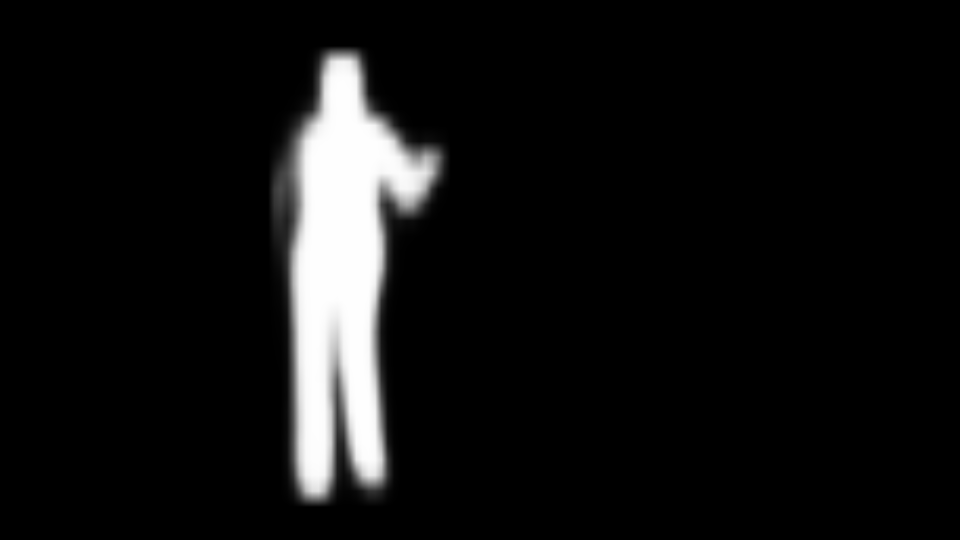

In [16]:
# Visualize a mask
Image.fromarray(outputs[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

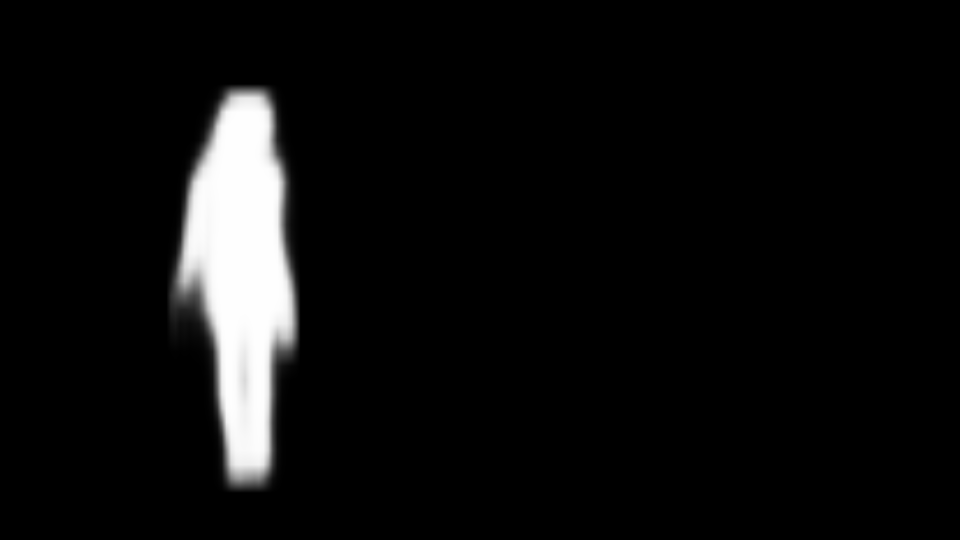

In [20]:
# Visualize a mask
Image.fromarray(outputs[5]['masks'][0, 0].mul(255).byte().cpu().numpy())